# Machine Learning Midterm - Online Transaction

## Rayhan Diff-1103220039

## Installing RAPIDS Library

In [1]:
!pip install cuml-cu12 --extra-index-url=https://pypi.nvidia.com
!pip install cudf-cu12 --extra-index-url=https://pypi.nvidia.com

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.2/581.2 MB 75.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.9/200.9 MB 120.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 MB 131.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.1/338.1 MB 60.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.5/366.5 MB 78.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 180.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.6/89.6 MB 139.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-cusparse-cu12
    Found existing installation: nvidia-cusparse-cu12 12.5.4.2
    Uninstalling nvidia-cusparse-cu12-12.5.4.2:
      Successfully uninstalled nvidia-cusparse-cu12-12.5.4.2
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.7.77
    Uninstalling nvidia-curand-cu12-10.3.7

## Import & Load

Import the necessary library and load data

## Load & Read Data

In [6]:
import cudf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cuml.cluster import KMeans
from cuml.preprocessing import StandardScaler
from cuml.decomposition import PCA
from cuml.metrics.cluster import silhouette_score
import io
from google.colab import drive
drive.mount('/content/drive')

import cudf
file_path = '/content/drive/MyDrive/Dataset_MLDL/clusteringmidterm.csv'

try:
    gdf = cudf.read_csv(file_path)
    print(f"Data Berhasil Dimuat. Shape: {gdf.shape}")
except FileNotFoundError:
    print("\nERROR: File tidak ditemukan!")
    print(f"Sistem mencari di lokasi: {file_path}")
    print("Mohon periksa kembali path file di variabel 'file_path' di atas.")
    raise

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data Berhasil Dimuat. Shape: (8950, 18)


## Data Cleaning and Preprocessing

In [7]:
if 'CUST_ID' in gdf.columns:
    gdf = gdf.drop('CUST_ID', axis=1)

for col in ['CREDIT_LIMIT', 'MINIMUM_PAYMENTS']:
    if gdf[col].isnull().any():
        median_val = gdf[col].median()
        gdf[col] = gdf[col].fillna(median_val)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(gdf)

print("Data Preprocessing Done.")

Data Preprocessing Done.


## Determining the Number of Clusters (Elbow Method)

Menghitung Elbow Method...


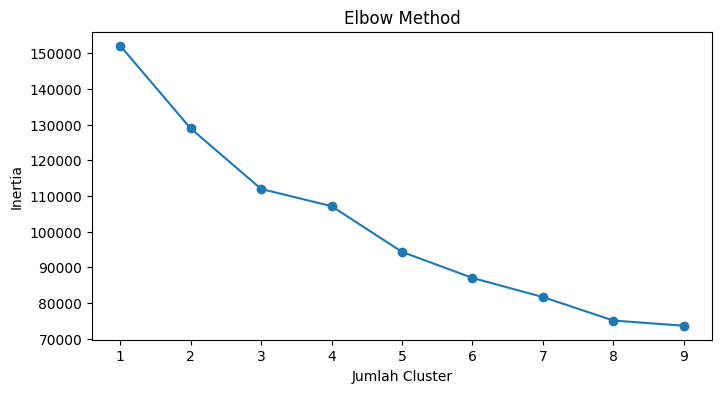

In [8]:
inertia = []
k_range = range(1, 10)

print("Menghitung Elbow Method...")
for k in k_range:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X_scaled)
    inertia.append(model.inertia_)

# Elbow Visualization
plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Jumlah Cluster')
plt.ylabel('Inertia')
plt.show()

## Using K-Means Model

In [9]:
k_optimal = 4
print(f"Melakukan Clustering dengan K={k_optimal}...")

kmeans = KMeans(n_clusters=k_optimal, random_state=42)
kmeans.fit(X_scaled)
labels = kmeans.predict(X_scaled)

# Evaluation with Silhouette Score
score = silhouette_score(X_scaled, labels)
print(f"Silhouette Score: {score:.4f}")

# Save the cluster results to the original DataFrame
gdf['Cluster'] = labels

Melakukan Clustering dengan K=4...
Silhouette Score: 0.2481


## Visualization

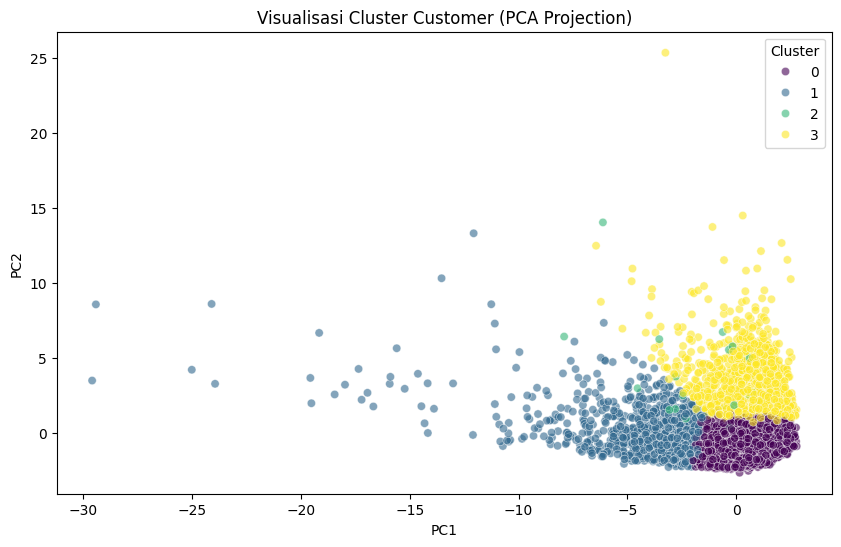

In [11]:
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

# Convert to pandas/numpy for visualization with Seaborn
df_viz = pd.DataFrame(components.to_numpy(), columns=['PC1', 'PC2'])
df_viz['Cluster'] = labels.to_numpy()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_viz, x='PC1', y='PC2', hue='Cluster', palette='viridis', alpha=0.6)
plt.title('Visualisasi Cluster Customer (PCA Projection)')
plt.show()

## Cluster Interpretation

In [12]:
df_pandas = gdf.to_pandas()
cluster_summary = df_pandas.groupby('Cluster').mean()

# Showing Key Features
key_features = ['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES',
                'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
                'CREDIT_LIMIT', 'PAYMENTS', 'PRC_FULL_PAYMENT']

print("\n--- Profil Tiap Cluster (Rata-rata) ---")
print(cluster_summary[key_features].round(2))


--- Profil Tiap Cluster (Rata-rata) ---
         BALANCE  PURCHASES  ONEOFF_PURCHASES  INSTALLMENTS_PURCHASES  \
Cluster                                                                 
0         797.44     506.29            253.40                  253.21   
1        2207.14    4273.82           2731.59                 1542.72   
2        4527.32    1001.41            228.04                  773.37   
3        3925.51     377.47            245.37                  132.18   

         CASH_ADVANCE  CREDIT_LIMIT  PAYMENTS  PRC_FULL_PAYMENT  
Cluster                                                          
0              324.80       3272.98    909.01              0.16  
1              460.95       7752.89   4161.45              0.30  
2             1477.02       4832.89   1965.20              0.00  
3             3862.53       6634.17   3000.16              0.03  


# Conclusion & Analysis

## 1. In-Depth Analysis of Customer Segments

Based on the *centroids* (mean values) produced by the **K-Means clustering model**, the customer base can be grouped into **4 distinct clusters**, each showing unique financial behaviors.

---

### **Cluster 0 – The Low-Activity Users (*Cost-Conscious*)**

**Observation:**  
- Lowest **BALANCE**: 797.44  
- Low **PURCHASES**: ~506  
- Very low **CASH_ADVANCE** usage  

**Behavior:**  
These customers rarely use their credit cards. They might be:  
- New or inactive users  
- Highly cost-conscious  
- Individuals who prefer cash/debit  

**Profitability:**  
*Low.* Minimal transaction fee and interest revenue.

---

### **Cluster 1 – The Prime Transactors (*High Spenders*)**

**Observation:**  
- Highest **PURCHASES**: 4,273.82  
- Active usage of one-off & installment purchases  
- Highest **PRC_FULL_PAYMENT**: 0.30  
- Highest **CREDIT_LIMIT**: ~7,752  

**Behavior:**  
These customers use credit cards primarily for convenience and consistently pay in full.

**Profitability:**  
*High* transaction-based revenue but *low* interest revenue.

---

### **Cluster 2 – The Revolvers (*Debt Carriers*)**

**Observation:**  
- High **BALANCE**: 4,527  
- **PRC_FULL_PAYMENT ≈ 0.00**  
- Moderate **PURCHASES**: ~1,000  

**Behavior:**  
Customers who frequently carry over unpaid balances and pay only minimum payments.

**Profitability:**  
*High* interest revenue but *moderate* default risk.

---

### **Cluster 3 – The Cash Advance Users (*High Risk*)**

**Observation:**  
- Very high **CASH_ADVANCE**: ~3,862  
- Low **PURCHASES**: ~377  

**Behavior:**  
Heavy reliance on cash advance indicates liquidity problems or financial distress.

**Profitability:**  
High fees, but **highest credit risk** among all clusters.

---

## 2. Technical Evaluation

### **Model Performance**

- The **Elbow Method** identified **K = 4** as optimal.  
- The **Silhouette Score = 0.2481** (acceptable for high-dimensional financial data).  
- Overlap between customer behaviors is expected due to complex financial patterns.

### **Efficiency (GPU Acceleration)**

Using **RAPIDS (cuDF + cuML)**:  
- Scaling, PCA, and K-Means on ~9,000 rows completed **within seconds**.  
- Much faster than CPU-based Scikit-Learn.  
- Scalable for much larger datasets.

---

## 3. Conclusion and Business Recommendations

The clustering pipeline successfully segmented customers into actionable financial groups. Below are recommended strategies for each cluster.

---

### **Cluster 1 – Prime Transactors (High Spenders)**  
**Strategy:** Retention & Up-selling  
**Actions:**  
- Offer premium cards (Gold/Platinum)  
- Provide travel perks, rewards, cashback  
- Increase credit limits  

---

### **Cluster 2 – The Revolvers (Debt Carriers)**  
**Strategy:** Interest Optimization & Risk Management  
**Actions:**  
- Monitor credit scores  
- Provide balance transfer options  
- Offer fixed-rate installment plans  

---

### **Cluster 3 – The Cash Advance Users (High Risk)**  
**Strategy:** Risk Mitigation  
**Actions:**  
- Reduce cash advance limits  
- Promote personal loans with lower interest rates  
- Closely monitor credit usage  

---

### **Cluster 0 – Low-Activity Users (Cost-Conscious)**  
**Strategy:** Activation & Engagement  
**Actions:**  
- Targeted marketing campaigns  
- Cashback incentives  
- Encourage usage for groceries, bills, utilities  
